In [1]:
#Imports and settings

import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import sys

import tensorflow as tf
from tqdm.notebook import tqdm


from sklearn.model_selection import train_test_split

np.set_printoptions(suppress=True)

In [2]:
# load the features and labels (subtract 1 as the labels aren't indexed from 0)
ytest = np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/test/y_test.txt')-1
ytrain = np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/train/y_train.txt')-1

In [3]:
# load the x,y,z body accelerations test data
xx_test=np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/test/Inertial Signals/body_acc_x_test.txt')
yy_test=np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/test/Inertial Signals/body_acc_y_test.txt')
zz_test=np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/test/Inertial Signals/body_acc_z_test.txt')
# concatenate the arrays along the last dimension
xtest = np.concatenate((xx_test[:,:,None],yy_test[:,:,None],zz_test[:,:,None]),axis=2)
# (using None here adds an extra dimension of size 1 to the end of the array)

In [4]:
# follow the same approach for the train data
xx_train=np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/train/Inertial Signals/body_acc_x_train.txt')
yy_train=np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/train/Inertial Signals/body_acc_y_train.txt')
zz_train=np.loadtxt('/home/jovyan/datasets/UCI_HAR_DATASET/train/Inertial Signals/body_acc_z_train.txt')
xtrain = np.concatenate((xx_train[:,:,None],yy_train[:,:,None],zz_train[:,:,None]),axis=2)

In [5]:
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(7352, 128, 3)
(2947, 128, 3)
(7352,)
(2947,)


plot one example data sample from
each of the body_acc_x_test, body_acc_y_test, and body_acc_z_test files for each of walking, sitting, standing, and
laying

In [6]:
#Set the labels (subtract 1 from original labels)
WALKING=0
WALKING_UPSTAIRS=1
WALKING_DOWNSTAIRS=2
SITTING=3
STANDING=4
LAYING=5

In [7]:
#Select random sample from activity
random_ts_walking = np.random.choice(np.where(ytest==WALKING)[0])
random_ts_sitting = np.random.choice(np.where(ytest==SITTING)[0])
random_ts_standing = np.random.choice(np.where(ytest==STANDING)[0])
random_ts_laying = np.random.choice(np.where(ytest==LAYING)[0])

In [8]:
num = [0,1,2,3]
samples = [random_ts_walking, random_ts_sitting, random_ts_standing, random_ts_laying]
activity = ['walking', 'sitting', 'standing', 'laying']

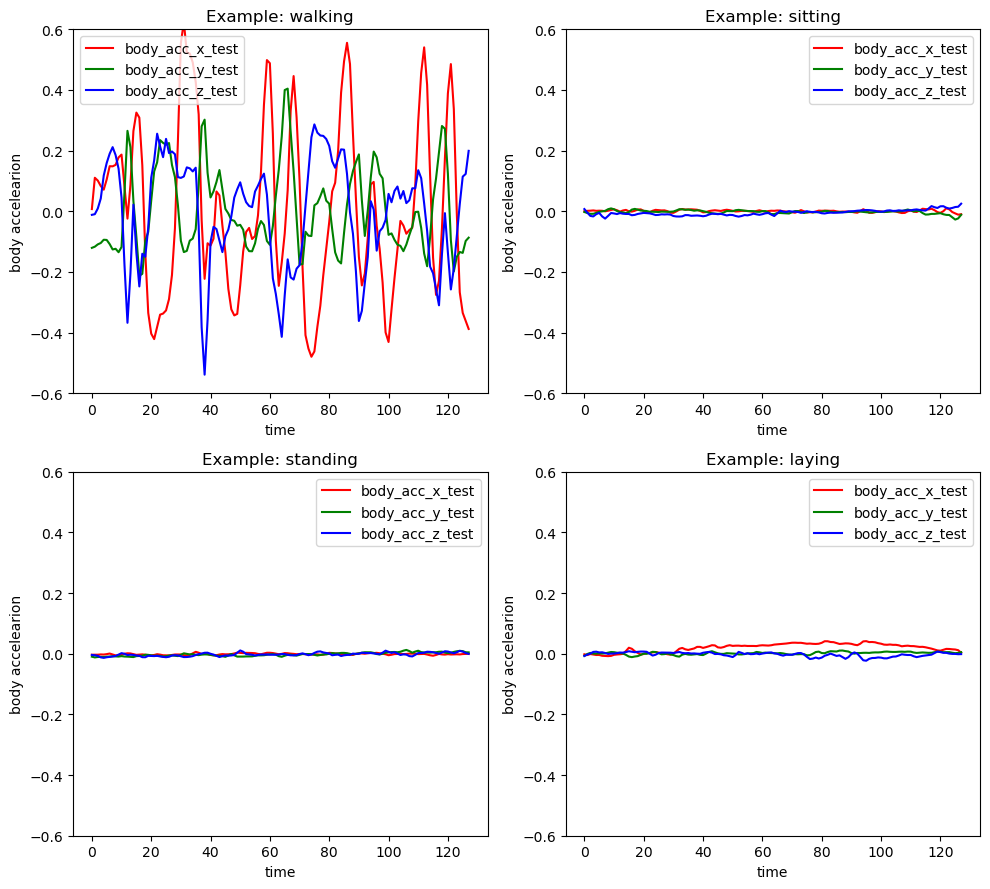

In [9]:
# Plotting examples of activites for body acceleration
fig, axs = plt.subplots(2,2, figsize=(10, 9), tight_layout=True)
fig.subplots_adjust(hspace = .5, wspace=.005)
time_series = np.arange(xtest.shape[1])
axs = axs.ravel()

import itertools
for (i,j,ax) in zip(samples,activity, num):
        axs[ax].plot(time_series, xtest[i, :, 0], color ='red', label='body_acc_x_test')
        axs[ax].plot(time_series, xtest[i, :, 1], color ='green', label='body_acc_y_test')
        axs[ax].plot(time_series, xtest[i, :, 2], color ='blue', label='body_acc_z_test')
        axs[ax].set(title=f'Example: {j}', xlabel='time', ylabel='body accelearion');
        axs[ax].legend()
        axs[ax].set_ylim(-0.6, 0.6)
    
             
plt.show()

#### Split the training data set into two using an 80:20 split, so that you have a train data array and a validation data array

In [10]:
x_input, x_val, y_input, y_val = train_test_split(xtrain, ytrain, test_size=0.2, random_state=10)
print(xtrain.shape)
print(xtest.shape)
print(y_input.shape)
print(y_val.shape)

(7352, 128, 3)
(2947, 128, 3)
(5881,)
(1471,)


#### You should now create a **single‐layer neural network to classify activities** based on each value of the body acceleration data for the 3 coordinates

In [11]:
#one-hot encoding for labels
y_input = tf.keras.utils.to_categorical(y_input)
y_val = tf.keras.utils.to_categorical(y_val)
print(y_input.shape)
print(y_val.shape)

(5881, 6)
(1471, 6)


In [12]:
#reshaping the last two dimension of the training data sensors
x_input = tf.reshape(x_input, (-1,128*3))
print ('x_train samples = ' + str(x_input.shape))

x_val = tf.reshape(x_val, (-1,128*3))
print ('x_val samples = ' + str(x_val.shape))

x_train samples = (5881, 384)
x_val samples = (1471, 384)


2023-07-11 08:07:54.106754: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-11 08:07:54.628584: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14660 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5


In [13]:
#change dtype for consistency
x_input = tf.cast(x_input, dtype=tf.float32)
x_val = tf.cast(x_val, dtype=tf.float32)
y_input = tf.cast(y_input, dtype=tf.float32)
y_val = tf.cast(y_val, dtype=tf.float32)

In [14]:
# Set up logging jupiterhub tensorboard
logdir = '/home/jovyan/logs/Project/part1'
writer = tf.summary.create_file_writer(logdir)

In [15]:
#Create weight tensors
W = tf.Variable(tf.zeros([384,6]),name='W', dtype=tf.float32)  #weight
b = tf.Variable(tf.zeros([6]),name='b', dtype=tf.float32)   #offset

# #using softmax activation layer on a vector with 6 entries
def y_pred(x):
    return tf.nn.softmax(tf.matmul(x,W) + b)
  
# cross entropy loss function
@tf.function
def loss(x,y):
    y_ = y_pred(x)
    return tf.reduce_mean(-tf.reduce_sum(y * tf.math.log(y_), axis=[1]))

#accuracy
def accuracy(x,y):
    y_ = y_pred(x)
    # calculate where the prediction equals the label
    correct = tf.math.equal(tf.math.argmax(y_,axis=-1),tf.math.argmax(y,axis=-1))
    # convert to a float (previously boolean)
    correct = tf.cast(correct,dtype=tf.float32)
    # return the mean to give the overall accuracy
    return tf.math.reduce_mean(correct)

In [16]:
# Selecting training parameters
n_iters = 5000
epochs = range(n_iters)

# learning rate
lr = 0.01

# gradient descent optimizer
optimizer = tf.keras.optimizers.Adam(lr) 


In [17]:
with writer.as_default():
    for i in tqdm(epochs):
        with tf.GradientTape() as tape:
            loss_train = loss(x_input, y_input)
            gradients = tape.gradient(loss_train, [W, b])
            optimizer.apply_gradients(zip(gradients, [W ,b]))
            loss_val = loss(x_val, y_val)
            tf.summary.scalar('loss_train', loss_train, step=i)  # write to tensorboard
            tf.summary.scalar('loss_val', loss_val, step=i)  # write to tensorboard
            train_acc = accuracy(x_input,y_input)
            val_acc = accuracy(x_val,y_val)
            tf.summary.scalar('train_acc', train_acc, step=i)  # write to tensorboard
            tf.summary.scalar('val_acc', val_acc, step=i)  # write to tensorboard
            if i%100 == 0:
                print('Training Step:' + str(i) + '  Loss = ' + str(loss_train))


  0%|          | 0/5000 [00:00<?, ?it/s]

Training Step:0  Loss = tf.Tensor(1.7917595, shape=(), dtype=float32)
Training Step:100  Loss = tf.Tensor(1.6431311, shape=(), dtype=float32)
Training Step:200  Loss = tf.Tensor(1.6188786, shape=(), dtype=float32)
Training Step:300  Loss = tf.Tensor(1.6067932, shape=(), dtype=float32)
Training Step:400  Loss = tf.Tensor(1.599984, shape=(), dtype=float32)
Training Step:500  Loss = tf.Tensor(1.595957, shape=(), dtype=float32)
Training Step:600  Loss = tf.Tensor(1.5934767, shape=(), dtype=float32)
Training Step:700  Loss = tf.Tensor(1.5918802, shape=(), dtype=float32)
Training Step:800  Loss = tf.Tensor(1.5908229, shape=(), dtype=float32)
Training Step:900  Loss = tf.Tensor(1.5900829, shape=(), dtype=float32)
Training Step:1000  Loss = tf.Tensor(1.5895412, shape=(), dtype=float32)
Training Step:1100  Loss = tf.Tensor(1.5891407, shape=(), dtype=float32)
Training Step:1200  Loss = tf.Tensor(1.5888026, shape=(), dtype=float32)
Training Step:1300  Loss = tf.Tensor(1.5885305, shape=(), dtype=f

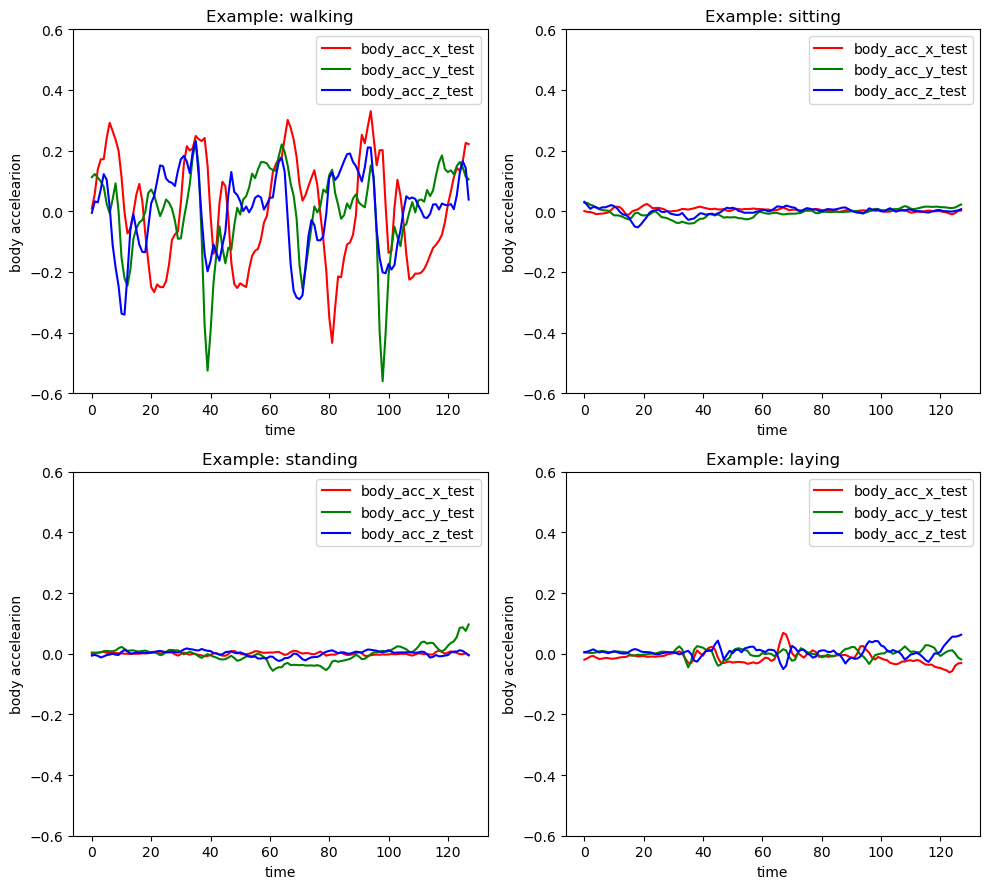

In [12]:
# Plotting examples of activites for body acceleration
fig, axs = plt.subplots(2,2, figsize=(10, 9), tight_layout=True)
fig.subplots_adjust(hspace = .5, wspace=.005)
time_series = np.arange(xtest.shape[1])
axs = axs.ravel()

import itertools
for (i,j,ax) in zip(samples,activity, num):
        axs[ax].plot(time_series, xtest[i, :, 0], color ='red', label='body_acc_x_test')
        axs[ax].plot(time_series, xtest[i, :, 1], color ='green', label='body_acc_y_test')
        axs[ax].plot(time_series, xtest[i, :, 2], color ='blue', label='body_acc_z_test')
        axs[ax].set(title=f'Example: {j}', xlabel='time', ylabel='body accelearion');
        axs[ax].legend()
        axs[ax].set_ylim(-0.6, 0.6)
    
             
plt.show()

Split the training data set into two using an 80:20 split, so that you have a train data array and a validation data array

In [ ]:
x_input, x_val, y_input, y_val = train_test_split(xtrain, ytrain, test_size=0.2, random_state=10)
print(xtrain.shape)
print(xtest.shape)
print(y_input.shape)
print(y_val.shape)

You should now create a **single‐layer neural network** to classify activities based on each value of the body acceleration data for the 3 coordinates

In [ ]:
#one-hot encoding for labels
y_input = tf.keras.utils.to_categorical(y_input)
y_val = tf.keras.utils.to_categorical(y_val)
print(y_input.shape)
print(y_val.shape)

In [ ]:
#reshaping
x_input = tf.reshape(x_input, (-1,128*3))
print ('X_train samples = ' + str(x_input.shape))

x_val = tf.reshape(x_val, (-1,128*3))
print ('x_val samples = ' + str(x_val.shape))

print ('y_input samples = ' + str(y_input.shape))
print ('y_val samples = ' + str(y_val.shape)

In [ ]:
#change dtype for consistency
x_input = tf.cast(x_input, dtype=tf.float32)
x_val = tf.cast(x_val, dtype=tf.float32)
y_input = tf.cast(y_input, dtype=tf.float32)
y_val = tf.cast(y_val, dtype=tf.float32)
x_input.dtype

In [ ]:
print(xtrain.shape)
print(xtest.shape)
print(y_input.shape)
print(y_val.shape)

In [ ]:
# Set up logging jupiterhub tensorboard
logdir = '/home/jovyan/logs/Project'
writer = tf.summary.create_file_writer(logdir)

In [ ]:
#Create weight tensors
W = tf.Variable(tf.zeros([384,6]),name='W', dtype=tf.float32)  #weight
b = tf.Variable(tf.zeros([6]),name='b', dtype=tf.float32)   #offset

# #using softmax activation layer on a vector with 6 entries
def y_pred(x):
    return tf.nn.softmax(tf.matmul(x,W) + b)

    
# cross entropy loss function
@tf.function
def loss(x,y):
    y_ = y_pred(x)
    return tf.reduce_mean(-tf.reduce_sum(y * tf.math.log(y_), axis=[1]))

#accuracy
def accuracy(x,y):
    y_ = y_pred(x)
    # calculate where the prediction equals the label
    correct = tf.math.equal(tf.math.argmax(y_,axis=-1),tf.math.argmax(y,axis=-1))
    # convert to a float (previously boolean)
    correct = tf.cast(correct,dtype=tf.float32)
    # return the mean to give the overall accuracy
    return tf.math.reduce_mean(correct)

In [ ]:
# Selecting training parameters
n_iters = 3000
epochs = range(n_iters)

# learning rate
lr = 0.1

# gradient descent optimizer
optimizer = tf.keras.optimizers.Adam(lr) 

In [23]:
with writer.as_default():
    for i in tqdm(epochs):
        with tf.GradientTape() as tape:
            current_loss = loss(x_input, y_input)
        gradients = tape.gradient(current_loss, [W, b])
        optimizer.apply_gradients(zip(gradients, [W ,b]))
        tf.summary.scalar('loss', current_loss, step=i)  # write to tensorboard
        train_acc = accuracy(x_input,y_input)
        val_acc = accuracy(X_val,y_val)
        tf.summary.scalar('train_acc', train_acc, step=i)  # write to tensorboard
        tf.summary.scalar('val_acc', val_acc, step=i)  # write to tensorboard
        if i%1000 == 0:
            print('Training Step:' + str(i) + '  Loss = ' + str(current_loss))


  0%|          | 0/5000 [00:00<?, ?it/s]

2023-07-11 08:00:52.934027: E tensorflow/stream_executor/cuda/cuda_blas.cc:232] failed to create cublas handle: CUBLAS_STATUS_NOT_INITIALIZED
2023-07-11 08:00:52.934058: E tensorflow/stream_executor/cuda/cuda_blas.cc:234] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2023-07-11 08:00:52.934077: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at matmul_op_impl.h:442 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support


InternalError: Graph execution error:

Detected at node 'MatMul' defined at (most recent call last):
    File "/opt/conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.8/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1096/3869918865.py", line 4, in <module>
      loss_train = loss(x_input, y_input)
    File "/tmp/ipykernel_1096/2054171854.py", line 12, in loss
      y_ = y_pred(x)
    File "/tmp/ipykernel_1096/2054171854.py", line 7, in y_pred
      return tf.nn.softmax(tf.matmul(x,W) + b)
Node: 'MatMul'
Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[{{node MatMul}}]] [Op:__forward_loss_90]

In [ ]:
# Test Deep Network - 2 layers - Sequential 

In [95]:
print ('x_input samples = ' + str(x_input.shape))
print ('y_input samples = ' + str(y_input.shape))
print ('x_val samples = ' + str(x_val.shape))
print ('y_val samples = ' + str(y_val.shape))

x_input samples = (5881, 384)
y_input samples = (5881, 6)
x_val samples = (1471, 384)
y_val samples = (1471, 6)


In [96]:
model = tf.keras.Sequential()
# Adds a densely-connected layer with 512 units to the model:
model.add(tf.keras.layers.Dense(512, activation='relu'))
# Add a softmax layer with 6 output units:
model.add(tf.keras.layers.Dense(6, activation='softmax'))

In [99]:
# Callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
# create a callback that will stop training if the validation loss hasn't improved for 2 epochs
#early_stopping_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
# initialize tqdm callback with default parameters
tqdm_callback = tfa.callbacks.TQDMProgressBar()

In [101]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_input, y_input, epochs=100, batch_size=256,validation_data=(x_val, y_val), callbacks=[tensorboard_callback, tqdm_callback])

Training:   0%|           0/100 ETA: ?s,  ?epochs/s

Epoch 1/100


0/23           ETA: ?s - 

Epoch 1/100
23/23 [==============================] - 0s 9ms/step - loss: 1.5200 - accuracy: 0.4312 - val_loss: 1.3455 - val_accuracy: 0.4949
Epoch 2/100


0/23           ETA: ?s - 

Epoch 2/100
23/23 [==============================] - 0s 4ms/step - loss: 1.2306 - accuracy: 0.5635 - val_loss: 1.1470 - val_accuracy: 0.5459
Epoch 3/100


0/23           ETA: ?s - 

Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 1.0387 - accuracy: 0.5943 - val_loss: 0.9775 - val_accuracy: 0.5894
Epoch 4/100


0/23           ETA: ?s - 

Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 0.8851 - accuracy: 0.6200 - val_loss: 0.8601 - val_accuracy: 0.5982
Epoch 5/100


0/23           ETA: ?s - 

Epoch 5/100
23/23 [==============================] - 0s 4ms/step - loss: 0.7919 - accuracy: 0.6286 - val_loss: 0.7979 - val_accuracy: 0.6057
Epoch 6/100


0/23           ETA: ?s - 

Epoch 6/100
23/23 [==============================] - 0s 4ms/step - loss: 0.7396 - accuracy: 0.6608 - val_loss: 0.7626 - val_accuracy: 0.6207
Epoch 7/100


0/23           ETA: ?s - 

Epoch 7/100
23/23 [==============================] - 0s 4ms/step - loss: 0.7077 - accuracy: 0.6647 - val_loss: 0.7351 - val_accuracy: 0.6370
Epoch 8/100


0/23           ETA: ?s - 

Epoch 8/100
23/23 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.6708 - val_loss: 0.7134 - val_accuracy: 0.6404
Epoch 9/100


0/23           ETA: ?s - 

Epoch 9/100
23/23 [==============================] - 0s 4ms/step - loss: 0.6602 - accuracy: 0.6949 - val_loss: 0.7008 - val_accuracy: 0.6615
Epoch 10/100


0/23           ETA: ?s - 

Epoch 10/100
23/23 [==============================] - 0s 4ms/step - loss: 0.6423 - accuracy: 0.7267 - val_loss: 0.6858 - val_accuracy: 0.6723
Epoch 11/100


0/23           ETA: ?s - 

Epoch 11/100
23/23 [==============================] - 0s 4ms/step - loss: 0.6259 - accuracy: 0.7332 - val_loss: 0.6717 - val_accuracy: 0.6825
Epoch 12/100


0/23           ETA: ?s - 

Epoch 12/100
23/23 [==============================] - 0s 4ms/step - loss: 0.6127 - accuracy: 0.7405 - val_loss: 0.6615 - val_accuracy: 0.7036
Epoch 13/100


0/23           ETA: ?s - 

Epoch 13/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5999 - accuracy: 0.7538 - val_loss: 0.6481 - val_accuracy: 0.7111
Epoch 14/100


0/23           ETA: ?s - 

Epoch 14/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5863 - accuracy: 0.7550 - val_loss: 0.6398 - val_accuracy: 0.7124
Epoch 15/100


0/23           ETA: ?s - 

Epoch 15/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5738 - accuracy: 0.7854 - val_loss: 0.6308 - val_accuracy: 0.7124
Epoch 16/100


0/23           ETA: ?s - 

Epoch 16/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5611 - accuracy: 0.7829 - val_loss: 0.6228 - val_accuracy: 0.7186
Epoch 17/100


0/23           ETA: ?s - 

Epoch 17/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5501 - accuracy: 0.7827 - val_loss: 0.6166 - val_accuracy: 0.7138
Epoch 18/100


0/23           ETA: ?s - 

Epoch 18/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5401 - accuracy: 0.7786 - val_loss: 0.6100 - val_accuracy: 0.7158
Epoch 19/100


0/23           ETA: ?s - 

Epoch 19/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5293 - accuracy: 0.7953 - val_loss: 0.6056 - val_accuracy: 0.7206
Epoch 20/100


0/23           ETA: ?s - 

Epoch 20/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5196 - accuracy: 0.7944 - val_loss: 0.5994 - val_accuracy: 0.7396
Epoch 21/100


0/23           ETA: ?s - 

Epoch 21/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5101 - accuracy: 0.8038 - val_loss: 0.5918 - val_accuracy: 0.7349
Epoch 22/100


0/23           ETA: ?s - 

Epoch 22/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5014 - accuracy: 0.8167 - val_loss: 0.5866 - val_accuracy: 0.7566
Epoch 23/100


0/23           ETA: ?s - 

Epoch 23/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4932 - accuracy: 0.8000 - val_loss: 0.5813 - val_accuracy: 0.7689
Epoch 24/100


0/23           ETA: ?s - 

Epoch 24/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4860 - accuracy: 0.8170 - val_loss: 0.5767 - val_accuracy: 0.7532
Epoch 25/100


0/23           ETA: ?s - 

Epoch 25/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4780 - accuracy: 0.8111 - val_loss: 0.5726 - val_accuracy: 0.7661
Epoch 26/100


0/23           ETA: ?s - 

Epoch 26/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4704 - accuracy: 0.8181 - val_loss: 0.5711 - val_accuracy: 0.7444
Epoch 27/100


0/23           ETA: ?s - 

Epoch 27/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4630 - accuracy: 0.8291 - val_loss: 0.5667 - val_accuracy: 0.7593
Epoch 28/100


0/23           ETA: ?s - 

Epoch 28/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4567 - accuracy: 0.8271 - val_loss: 0.5626 - val_accuracy: 0.7573
Epoch 29/100


0/23           ETA: ?s - 

Epoch 29/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4500 - accuracy: 0.8298 - val_loss: 0.5600 - val_accuracy: 0.7763
Epoch 30/100


0/23           ETA: ?s - 

Epoch 30/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4449 - accuracy: 0.8318 - val_loss: 0.5581 - val_accuracy: 0.7661
Epoch 31/100


0/23           ETA: ?s - 

Epoch 31/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4380 - accuracy: 0.8422 - val_loss: 0.5536 - val_accuracy: 0.7784
Epoch 32/100


0/23           ETA: ?s - 

Epoch 32/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4327 - accuracy: 0.8417 - val_loss: 0.5553 - val_accuracy: 0.7525
Epoch 33/100


0/23           ETA: ?s - 

Epoch 33/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4275 - accuracy: 0.8374 - val_loss: 0.5472 - val_accuracy: 0.7777
Epoch 34/100


0/23           ETA: ?s - 

Epoch 34/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4225 - accuracy: 0.8388 - val_loss: 0.5453 - val_accuracy: 0.7777
Epoch 35/100


0/23           ETA: ?s - 

Epoch 35/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4166 - accuracy: 0.8507 - val_loss: 0.5437 - val_accuracy: 0.7859
Epoch 36/100


0/23           ETA: ?s - 

Epoch 36/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4116 - accuracy: 0.8572 - val_loss: 0.5411 - val_accuracy: 0.7811
Epoch 37/100


0/23           ETA: ?s - 

Epoch 37/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4066 - accuracy: 0.8575 - val_loss: 0.5380 - val_accuracy: 0.7886
Epoch 38/100


0/23           ETA: ?s - 

Epoch 38/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4014 - accuracy: 0.8616 - val_loss: 0.5381 - val_accuracy: 0.7831
Epoch 39/100


0/23           ETA: ?s - 

Epoch 39/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3967 - accuracy: 0.8643 - val_loss: 0.5350 - val_accuracy: 0.7859
Epoch 40/100


0/23           ETA: ?s - 

Epoch 40/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3930 - accuracy: 0.8631 - val_loss: 0.5316 - val_accuracy: 0.7906
Epoch 41/100


0/23           ETA: ?s - 

Epoch 41/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3883 - accuracy: 0.8657 - val_loss: 0.5350 - val_accuracy: 0.7893
Epoch 42/100


0/23           ETA: ?s - 

Epoch 42/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3848 - accuracy: 0.8657 - val_loss: 0.5293 - val_accuracy: 0.7920
Epoch 43/100


0/23           ETA: ?s - 

Epoch 43/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3787 - accuracy: 0.8701 - val_loss: 0.5288 - val_accuracy: 0.7852
Epoch 44/100


0/23           ETA: ?s - 

Epoch 44/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3751 - accuracy: 0.8747 - val_loss: 0.5251 - val_accuracy: 0.7920
Epoch 45/100


0/23           ETA: ?s - 

Epoch 45/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3710 - accuracy: 0.8706 - val_loss: 0.5303 - val_accuracy: 0.7723
Epoch 46/100


0/23           ETA: ?s - 

Epoch 46/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3662 - accuracy: 0.8762 - val_loss: 0.5238 - val_accuracy: 0.7927
Epoch 47/100


0/23           ETA: ?s - 

Epoch 47/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3631 - accuracy: 0.8764 - val_loss: 0.5246 - val_accuracy: 0.7940
Epoch 48/100


0/23           ETA: ?s - 

Epoch 48/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3595 - accuracy: 0.8788 - val_loss: 0.5206 - val_accuracy: 0.7974
Epoch 49/100


0/23           ETA: ?s - 

Epoch 49/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3544 - accuracy: 0.8798 - val_loss: 0.5179 - val_accuracy: 0.7988
Epoch 50/100


0/23           ETA: ?s - 

Epoch 50/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3502 - accuracy: 0.8825 - val_loss: 0.5159 - val_accuracy: 0.7995
Epoch 51/100


0/23           ETA: ?s - 

Epoch 51/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3464 - accuracy: 0.8881 - val_loss: 0.5152 - val_accuracy: 0.7961
Epoch 52/100


0/23           ETA: ?s - 

Epoch 52/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3423 - accuracy: 0.8835 - val_loss: 0.5187 - val_accuracy: 0.7974
Epoch 53/100


0/23           ETA: ?s - 

Epoch 53/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3399 - accuracy: 0.8840 - val_loss: 0.5176 - val_accuracy: 0.7906
Epoch 54/100


0/23           ETA: ?s - 

Epoch 54/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3356 - accuracy: 0.8890 - val_loss: 0.5108 - val_accuracy: 0.8056
Epoch 55/100


0/23           ETA: ?s - 

Epoch 55/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3319 - accuracy: 0.8888 - val_loss: 0.5160 - val_accuracy: 0.8124
Epoch 56/100


0/23           ETA: ?s - 

Epoch 56/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3279 - accuracy: 0.8903 - val_loss: 0.5126 - val_accuracy: 0.8124
Epoch 57/100


0/23           ETA: ?s - 

Epoch 57/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3259 - accuracy: 0.8898 - val_loss: 0.5083 - val_accuracy: 0.8090
Epoch 58/100


0/23           ETA: ?s - 

Epoch 58/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3207 - accuracy: 0.8968 - val_loss: 0.5096 - val_accuracy: 0.8042
Epoch 59/100


0/23           ETA: ?s - 

Epoch 59/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3190 - accuracy: 0.8898 - val_loss: 0.5109 - val_accuracy: 0.8069
Epoch 60/100


0/23           ETA: ?s - 

Epoch 60/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3151 - accuracy: 0.8983 - val_loss: 0.5061 - val_accuracy: 0.8063
Epoch 61/100


0/23           ETA: ?s - 

Epoch 61/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3114 - accuracy: 0.8976 - val_loss: 0.5123 - val_accuracy: 0.8110
Epoch 62/100


0/23           ETA: ?s - 

Epoch 62/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3088 - accuracy: 0.8993 - val_loss: 0.5067 - val_accuracy: 0.8083
Epoch 63/100


0/23           ETA: ?s - 

Epoch 63/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3055 - accuracy: 0.9005 - val_loss: 0.5079 - val_accuracy: 0.8124
Epoch 64/100


0/23           ETA: ?s - 

Epoch 64/100
23/23 [==============================] - 0s 4ms/step - loss: 0.3012 - accuracy: 0.9055 - val_loss: 0.5078 - val_accuracy: 0.8124
Epoch 65/100


0/23           ETA: ?s - 

Epoch 65/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2986 - accuracy: 0.9038 - val_loss: 0.5086 - val_accuracy: 0.8165
Epoch 66/100


0/23           ETA: ?s - 

Epoch 66/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2957 - accuracy: 0.9046 - val_loss: 0.5102 - val_accuracy: 0.8137
Epoch 67/100


0/23           ETA: ?s - 

Epoch 67/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2927 - accuracy: 0.9090 - val_loss: 0.5104 - val_accuracy: 0.8151
Epoch 68/100


0/23           ETA: ?s - 

Epoch 68/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2899 - accuracy: 0.9087 - val_loss: 0.5102 - val_accuracy: 0.8076
Epoch 69/100


0/23           ETA: ?s - 

Epoch 69/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2866 - accuracy: 0.9055 - val_loss: 0.5173 - val_accuracy: 0.8056
Epoch 70/100


0/23           ETA: ?s - 

Epoch 70/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2846 - accuracy: 0.9085 - val_loss: 0.5120 - val_accuracy: 0.8090
Epoch 71/100


0/23           ETA: ?s - 

Epoch 71/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2811 - accuracy: 0.9129 - val_loss: 0.5091 - val_accuracy: 0.8185
Epoch 72/100


0/23           ETA: ?s - 

Epoch 72/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2781 - accuracy: 0.9129 - val_loss: 0.5099 - val_accuracy: 0.8117
Epoch 73/100


0/23           ETA: ?s - 

Epoch 73/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2755 - accuracy: 0.9141 - val_loss: 0.5110 - val_accuracy: 0.8090
Epoch 74/100


0/23           ETA: ?s - 

Epoch 74/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2734 - accuracy: 0.9140 - val_loss: 0.5134 - val_accuracy: 0.8110
Epoch 75/100


0/23           ETA: ?s - 

Epoch 75/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2718 - accuracy: 0.9157 - val_loss: 0.5093 - val_accuracy: 0.8137
Epoch 76/100


0/23           ETA: ?s - 

Epoch 76/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2687 - accuracy: 0.9158 - val_loss: 0.5131 - val_accuracy: 0.8144
Epoch 77/100


0/23           ETA: ?s - 

Epoch 77/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2664 - accuracy: 0.9187 - val_loss: 0.5086 - val_accuracy: 0.8171
Epoch 78/100


0/23           ETA: ?s - 

Epoch 78/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2631 - accuracy: 0.9194 - val_loss: 0.5114 - val_accuracy: 0.8131
Epoch 79/100


0/23           ETA: ?s - 

Epoch 79/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2603 - accuracy: 0.9196 - val_loss: 0.5115 - val_accuracy: 0.8178
Epoch 80/100


0/23           ETA: ?s - 

Epoch 80/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2575 - accuracy: 0.9218 - val_loss: 0.5144 - val_accuracy: 0.8144
Epoch 81/100


0/23           ETA: ?s - 

Epoch 81/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2558 - accuracy: 0.9238 - val_loss: 0.5165 - val_accuracy: 0.8090
Epoch 82/100


0/23           ETA: ?s - 

Epoch 82/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2541 - accuracy: 0.9240 - val_loss: 0.5191 - val_accuracy: 0.8158
Epoch 83/100


0/23           ETA: ?s - 

Epoch 83/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2515 - accuracy: 0.9220 - val_loss: 0.5220 - val_accuracy: 0.8117
Epoch 84/100


0/23           ETA: ?s - 

Epoch 84/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2480 - accuracy: 0.9247 - val_loss: 0.5227 - val_accuracy: 0.8137
Epoch 85/100


0/23           ETA: ?s - 

Epoch 85/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2460 - accuracy: 0.9243 - val_loss: 0.5153 - val_accuracy: 0.8151
Epoch 86/100


0/23           ETA: ?s - 

Epoch 86/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2441 - accuracy: 0.9291 - val_loss: 0.5243 - val_accuracy: 0.8124
Epoch 87/100


0/23           ETA: ?s - 

Epoch 87/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2413 - accuracy: 0.9269 - val_loss: 0.5304 - val_accuracy: 0.8063
Epoch 88/100


0/23           ETA: ?s - 

Epoch 88/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2394 - accuracy: 0.9291 - val_loss: 0.5261 - val_accuracy: 0.8117
Epoch 89/100


0/23           ETA: ?s - 

Epoch 89/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2363 - accuracy: 0.9298 - val_loss: 0.5245 - val_accuracy: 0.8090
Epoch 90/100


0/23           ETA: ?s - 

Epoch 90/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2341 - accuracy: 0.9325 - val_loss: 0.5264 - val_accuracy: 0.8137
Epoch 91/100


0/23           ETA: ?s - 

Epoch 91/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2327 - accuracy: 0.9322 - val_loss: 0.5297 - val_accuracy: 0.8137
Epoch 92/100


0/23           ETA: ?s - 

Epoch 92/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2296 - accuracy: 0.9333 - val_loss: 0.5322 - val_accuracy: 0.8063
Epoch 93/100


0/23           ETA: ?s - 

Epoch 93/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2280 - accuracy: 0.9349 - val_loss: 0.5347 - val_accuracy: 0.8063
Epoch 94/100


0/23           ETA: ?s - 

Epoch 94/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2261 - accuracy: 0.9362 - val_loss: 0.5340 - val_accuracy: 0.8097
Epoch 95/100


0/23           ETA: ?s - 

Epoch 95/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2237 - accuracy: 0.9378 - val_loss: 0.5312 - val_accuracy: 0.8097
Epoch 96/100


0/23           ETA: ?s - 

Epoch 96/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2219 - accuracy: 0.9357 - val_loss: 0.5356 - val_accuracy: 0.8083
Epoch 97/100


0/23           ETA: ?s - 

Epoch 97/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2192 - accuracy: 0.9395 - val_loss: 0.5353 - val_accuracy: 0.8076
Epoch 98/100


0/23           ETA: ?s - 

Epoch 98/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2176 - accuracy: 0.9408 - val_loss: 0.5395 - val_accuracy: 0.8083
Epoch 99/100


0/23           ETA: ?s - 

Epoch 99/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2153 - accuracy: 0.9391 - val_loss: 0.5376 - val_accuracy: 0.8103
Epoch 100/100


0/23           ETA: ?s - 

Epoch 100/100
23/23 [==============================] - 0s 4ms/step - loss: 0.2139 - accuracy: 0.9378 - val_loss: 0.5383 - val_accuracy: 0.8131
